In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import keras
from keras import models, layers
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.applications import InceptionV3
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

from sklearn.metrics import classification_report, accuracy_score, roc_auc_score 

Using TensorFlow backend.


## Detecting Breast Cancer with Inception V3 and Transfer Learning

Inception V3 is a great convolutional neural network created by google. This architecture uses a lot of parameter reduction techniques to keep it's parameters very low. Only 21 million parameters , but there are 94 convolutional layers in this network. It's a very deep network. 

Transfer learning is a powerful technique, because it saves us a lot of training time by transfering pre-trained weights. The weights we used were trained on the popular machine learning competition data set imagenet. InceptionV3 was the top performing model in 2015 under 25mil parameters.

There are many different approaches to transfer learning. You can freeze the first couple of layers, or you can freeze all but the last layers, and only train on a few of the layers. In both these techniques you have to modify the output of the model to fit your new problem. Another transfer learning technique is to transfer some of the weights from a few of the layers to a completely new model. 

The approach we used in this data set is to train over the whole model with a very small learning rate. This is a good technique for this problem because mammograms are very different from the images you see in the imagenet challenge. However, the pre-trained weights and bias are a lot stronger than random weights and that saves us a lot of time, often these networks with out pretrained weights will takes days to train.

In [2]:
#Loops through ImageDataGenerator and grabs true labels and predictions
#and reports metrics with classification_report method
def predict_and_report(gen, model):
    y_true = []
    y_pred = []
    gen.reset()
    for img, label in gen:
        #get true labels for batch and store them
        y_true.extend([int(z[1]) for z in label])
        #Get predictions as probabilities
        batch_pred = model.predict_on_batch(img)
        #turn probabilities to class labels and store
        batch_pred = np.argmax(batch_pred, axis=1)
        y_pred.extend(batch_pred)
        #break loop
        if gen.batch_index == 0:
            break
            
    print('Accuracy:', accuracy_score(y_true, y_pred))
    print('Area Under the Receiver Operating Characteristic Curve:', roc_auc_score(y_true, y_pred)) #Area under the curve
    print(classification_report(y_true, y_pred))

## Parameters

As for the network architecture itself we are going to leave that up to the smart people at google who created the inception V3 network. However, this still leaves us with quiet a few parameters to adjust ourselves. Here are the parameters: Batch size, learning rate, decay, number of epochs, and data augmentation.

For batch size we chose the highest batch size that our GPU memory would allow. This is a batch size of 64, this is a strong batch size even if we had more computational power. A higher batch size means we have a better representation of the data set. Which means our model is going to converge faster and have less variation when the model trys to find the optimal minimum in our gradient. 

For learning rate I tested different learning rates for one epoch. I chose the learning rate that was one decimal place lower than the learning rate that gave us the lowest validation loss after one epoch. This learning rate was 1e-5. If our learning rate is too high then the pre-trained weights will be destroyed and our model will have very poor results. If the learning rate is very low the model might not learn fast enough. So we went with a very safe learning rate and trained for a bit longer then we needed. This model took us about 10 hours to train on a local GPU.

For decay we just did a linear decay. Which was learning rate divided by the number of epochs, and subtracted that number after every epoch. Using this technique the learning rate is near zero by the last epoch. By lowering the learning rate after each epoch we can be sure that our model has a better chance of reaching an optimal minimum in our gradient.

As for data augmentation we went with a pretty standard set of augmenation. There's a shear, a zoom, and both horizontal and vertical flips. I assumed that cancer has no orientation. these augmentations produced good results.

One important technique we used was a model check point. This saves the model weights for each epoch that has the best score. We can use these weights that were saved at a mid point during training. This helps us ensure that the model weights we use do not over fit on the training data, and generalize well to new data. It is also important just to keep the model weights with the best results.

In [3]:
train_dir = 'C:\\users\\will\\ds\\mammo\\train'
valid_dir = 'C:\\users\\will\\ds\\mammo\\validation'
test_dir = 'C:\\users\\will\\ds\\mammo\\test'

img_width, img_height = 299, 299
batch_size = 64
num_epochs= 75
learning_rate = 1e-5
#First epoch loss for different learning rates.
#1e-3 loss: 0.0679 - acc: 0.8581 - val_loss: 1.7522 - val_acc: 0.5769
#1e-4 loss: 0.0449 - acc: 0.9106 - val_loss: 0.1305 - val_acc: 0.9489
#1e-5 loss: 0.0702 - acc: 0.8506 - val_loss: 0.1667 - val_acc: 0.9398
decay = learning_rate / num_epochs

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb') #using RGB here because inception V3 is a 3 channel model

validation_generator = test_datagen.flow_from_directory(
    valid_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb')

Found 39011 images belonging to 2 classes.
Found 8436 images belonging to 2 classes.
Found 8438 images belonging to 2 classes.


In [4]:
#Load the InceptionV3 model and imagenet weights
IV3 = InceptionV3(weights='imagenet', include_top=True, input_shape=(img_width, img_height, 3))    

# modify output for 2 classes
fc2 = IV3.get_layer('avg_pool').output
predictions = Dense(2, activation='softmax', name='predictions')(fc2)
model = Model(inputs=IV3.input, outputs=predictions)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [5]:
adam = keras.optimizers.Adam(lr=learning_rate, decay=decay)

model.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

#Save best weights
filepath="C:\\users\\will\\ds\\mammo-weights-transfer\\weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

result = model.fit_generator(
            train_generator,
            epochs=num_epochs,
            verbose = 1,
            class_weight= {0:.13, 1:.87},
            validation_data = validation_generator,
            callbacks=callbacks_list)

Epoch 1/75
610/610 [==============================] - 529s 866ms/step - loss: 0.0691 - acc: 0.8560 - val_loss: 0.1940 - val_acc: 0.9266

Epoch 00001: val_loss improved from inf to 0.19396, saving model to C:\users\will\ds\mammo-weights-transfer\weights-improvement-01-0.93.hdf5
Epoch 2/75
610/610 [==============================] - 499s 819ms/step - loss: 0.0391 - acc: 0.9286 - val_loss: 0.1456 - val_acc: 0.9484

Epoch 00002: val_loss improved from 0.19396 to 0.14565, saving model to C:\users\will\ds\mammo-weights-transfer\weights-improvement-02-0.95.hdf5
Epoch 3/75
610/610 [==============================] - 500s 819ms/step - loss: 0.0325 - acc: 0.9433 - val_loss: 0.1268 - val_acc: 0.9531

Epoch 00003: val_loss improved from 0.14565 to 0.12681, saving model to C:\users\will\ds\mammo-weights-transfer\weights-improvement-03-0.95.hdf5
Epoch 4/75
610/610 [==============================] - 499s 817ms/step - loss: 0.0269 - acc: 0.9510 - val_loss: 0.1526 - val_acc: 0.9432

Epoch 00004: val_loss

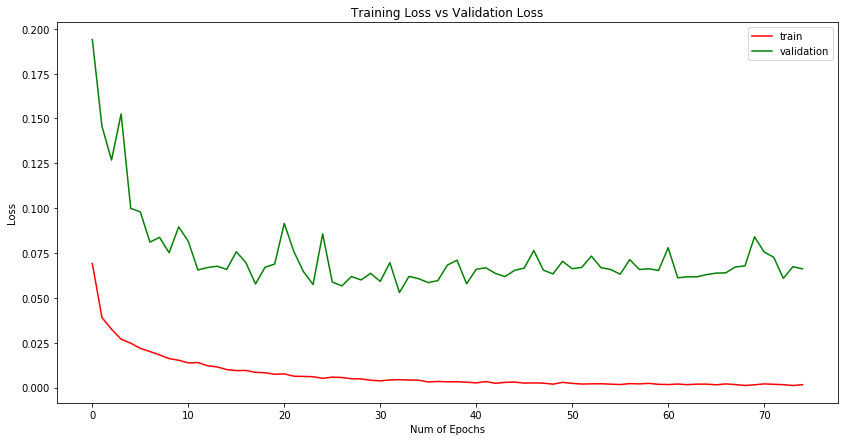

In [6]:
plt.figure(figsize=(14, 7))
plt.plot(result.history['loss'],'r')
plt.plot(result.history['val_loss'],'g')
plt.xticks(np.arange(0, num_epochs+1, 10.0))
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])
plt.show()

## Learning rate

This is a healthy learning rate, the epoch with the best score was epoch 33. We used these weights saved at epoch 33 below to see how accurate the model is on validation and train data sets. 

In [10]:
model.load_weights('mammo-weights-transfer\weights-improvement-33-0.98.hdf5')
predict_and_report(validation_generator, model)
predict_and_report(train_generator, model)

Accuracy: 0.9848269321953532
Area Under the Receiver Operating Characteristic Curve: 0.9648074315413139
             precision    recall  f1-score   support

          0       0.99      0.99      0.99      7343
          1       0.94      0.94      0.94      1093

avg / total       0.98      0.98      0.98      8436

Accuracy: 0.9974366204403886
Area Under the Receiver Operating Characteristic Curve: 0.9971101228009448
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     33909
          1       0.98      1.00      0.99      5102

avg / total       1.00      1.00      1.00     39011

